In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split

5.1 Effects of interpolatoin techniques in image resize

show grid

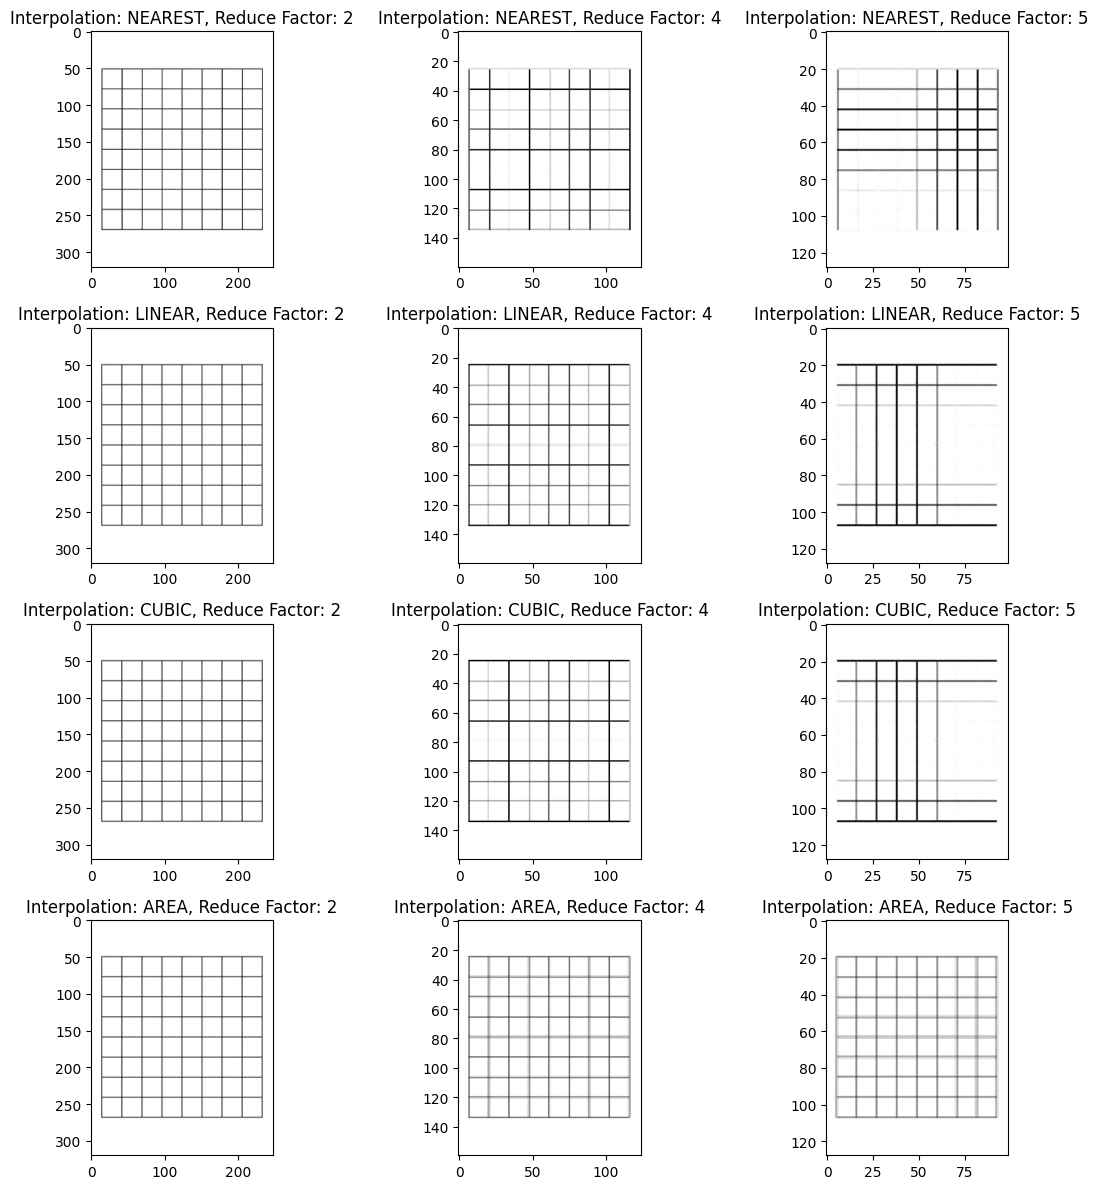

In [2]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("images/gridimage.jpg")
inter_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
name_methods = ["NEAREST","LINEAR","CUBIC","AREA"]
reduce_factors = [2, 4, 5]
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i, inter_method in enumerate(inter_methods):
    for j, reduce_factor in enumerate(reduce_factors):
        resized_image = cv2.resize(image, None, fx=1/reduce_factor, fy=1/reduce_factor, interpolation=inter_method)
        axes[i, j].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        axes[i, j].set_title(f'Interpolation: {name_methods[i]}, Reduce Factor: {reduce_factor}')
plt.tight_layout()
plt.show()


with real image 

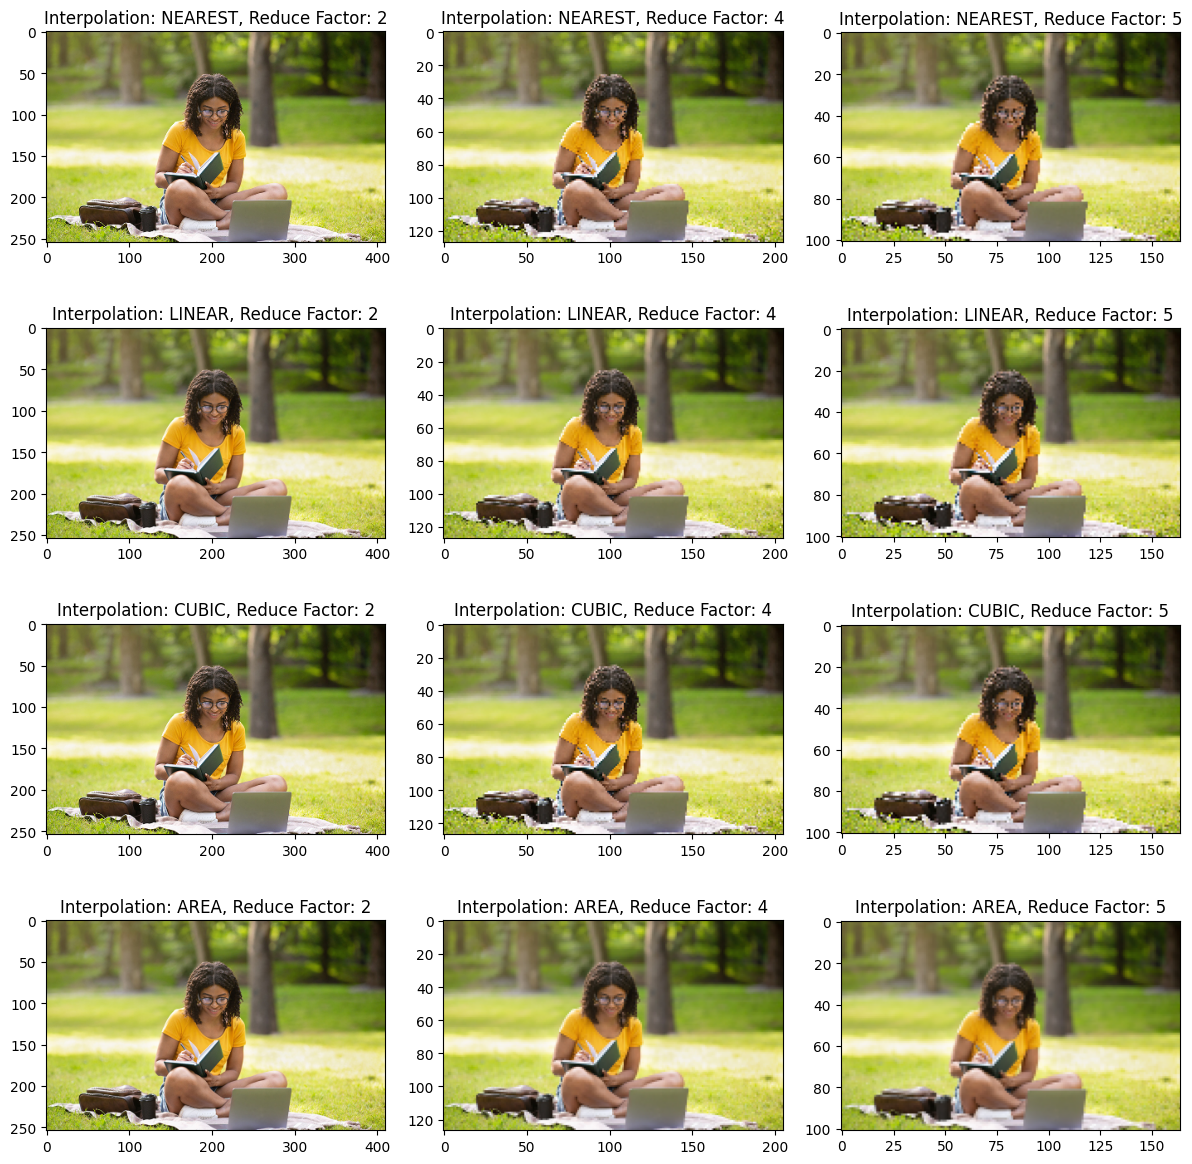

In [3]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("images/girl2.jpg")
inter_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
name_methods = ["NEAREST","LINEAR","CUBIC","AREA"]
reduce_factors = [2, 4, 5]
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i, inter_method in enumerate(inter_methods):
    for j, reduce_factor in enumerate(reduce_factors):
        resized_image = cv2.resize(image, None, fx=1/reduce_factor, fy=1/reduce_factor, interpolation=inter_method)
        axes[i, j].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        axes[i, j].set_title(f'Interpolation: {name_methods[i]}, Reduce Factor: {reduce_factor}')
plt.tight_layout()
plt.show()

5.2 IMAGE AUGMENTATION USING KERAS IMAGEDATAGENERATOR

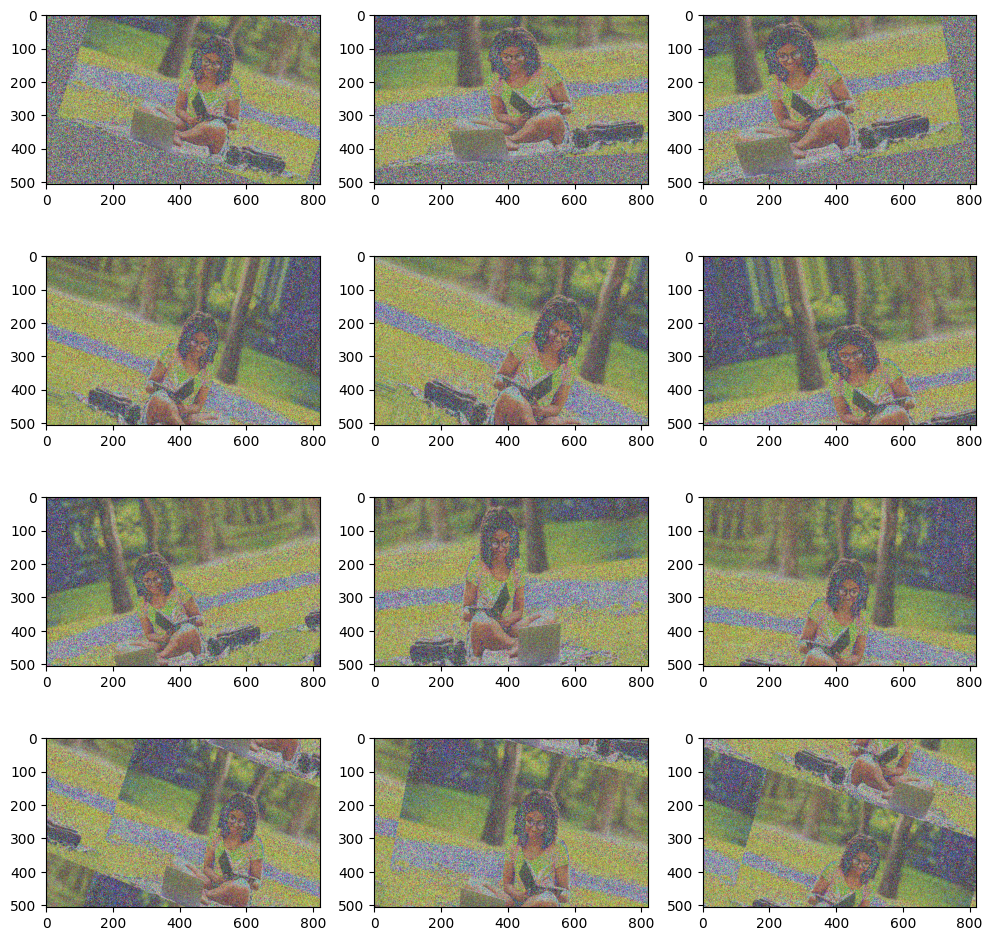

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Load the image
img = cv2.imread("images/girl2.jpg")
imgs = [img]
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
# Define the function to add Gaussian noise
def add_gaussian_noise(img):
    noise = np.random.normal(loc=0, scale=50, size=img.shape)
    noisy_img = img + noise
    return noisy_img

# List of fill methods
fill_methods = ['constant', 'nearest', 'reflect', 'wrap']

for i,fill_method in enumerate(fill_methods):
    # Create the ImageDataGenerator with specified augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.5,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=add_gaussian_noise,
        fill_mode=fill_method
    )
    imgs_array = np.array(imgs)
    augmented_images = datagen.flow(imgs_array, batch_size=1)
    for j in range(3):
        batch = augmented_images.next()
        im_result = batch[0].astype('uint8')
        axes[i, j].imshow(cv2.cvtColor(im_result,cv2.COLOR_BGR2RGB))
        


5.3 IMAGE AUGMENTATION AS TRAINING DATA FOR AUTOENCODER

In [4]:
(X_train,_),(X_test,_) = fashion_mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0
X_train,X_val = train_test_split(X_train, random_state=42, test_size=0.3)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [7]:
print(X_train.shape)

(42000, 28, 28, 1)


(-0.5, 27.5, 27.5, -0.5)

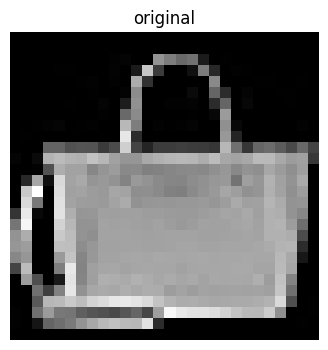

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_val[0],cmap='gray')
plt.title('original')
plt.axis('off')

In [7]:
print(X_train[0].min(), X_train[0].max())
print(X_train.shape)
print(X_val[0].min(), X_val[0].max())

0.0 1.0
(42000, 28, 28, 1)
0.0 1.0


(-0.5, 27.5, 27.5, -0.5)

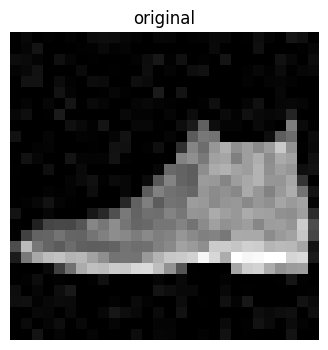

In [16]:
x_test_noisy = add_gaussian_noise(X_test[0])
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy,cmap='gray')
plt.title('original')
plt.axis('off')

In [14]:
import tensorflow as tf
Input_img = Input(shape=(28, 28, 1))
def add_gaussian_noise(img):
  noise = 0.2*np.random.normal(loc=0,scale=0.2,size=img.shape)
  noisy_img = img + noise
  np.clip(noisy_img, 0.0, 1.0, out = noisy_img)
  return noisy_img

def create_autoencoder(optimizer='adam', learning_rate=0.001):
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x3 = MaxPool2D((2, 2), strides=(2, 2))(x2)
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
    x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
    x6 = UpSampling2D((2, 2))(x5)
    x7 = Conv2D(128, (3, 3), activation='relu', padding='same')(x6)
    x8 = Conv2D(256, (3, 3), activation='relu', padding='same')(x7)
    x9 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = Model(Input_img,x9)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
    # model.summary()
    return model

In [6]:
autoencoder = create_autoencoder('adam',0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                             

In [26]:
eps = 10
bs = 128
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=add_gaussian_noise,
        fill_mode="nearest"
    )
autoencoder = create_autoencoder('adam',0.001)
callback = EarlyStopping(monitor='loss', patience=10)
history = autoencoder.fit_generator(datagen.flow(X_train, X_train, batch_size=bs, shuffle=False),
epochs=eps, steps_per_epoch = X_train.shape[0]//bs,
validation_data=datagen.flow(X_val, X_val, batch_size=bs),
callbacks=[callback],verbose=1)

(28, 28)


ValueError: in user code:

    File "d:\Python310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "d:\Python310\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Python310\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Python310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "d:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Python310\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model_13" (type Functional).
    
    Input 0 of layer "conv2d_91" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 28)
    
    Call arguments received by layer "model_13" (type Functional):
      • inputs=tf.Tensor(shape=(None, 28), dtype=float32)
      • training=False
      • mask=None


In [ ]:
import matplotlib.pyplot as plt

# Access the training loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('model_loss_plot.png')
plt.show()

In [ ]:
x_test_noisy = add_gaussian_noise(X_test)
predict_test = autoencoder.predict(x_test_noisy)
plt.imsave('test_prediction_plt.png',predict_test)
cv2.imwrite('test_predictation_cv2.png',predict_test)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy,cmap='gray')
plt.title('original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(predict_test,cmap='gray')
plt.title('predict image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
titles = ["original","add noise","predict"]
for i in range(5):
    for j in range(3):
        plt.subplot(5,3, (i*5)+j+1)
        if j == 0 :
            plt.imshow(X_test[i],cmap='gray')
        elif j == 1 : 
            plt.imshow(x_test_noisy[i],cmap='gray')
        else : 
            plt.imshow(predict_test[i],cmap='gray')
        plt.title(titles[j])
        plt.axis('off')
        plt.tight_layout()
plt.savefig('model_loss_plot.png')
plt.show()